![](header.jpg)

# Optimizing SVC with Grid Search

Kevin J. Walchko, Phd

9 Jan 2021

---

Grid search will allow us to run a model over a range of parameters to find the optimal values.

## References

- udemy class on machine learning
- scikit-learn: [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

## Importing the libraries

In [12]:
import numpy as np
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import pandas as pd

from colorama import Fore

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [11]:
# helper function
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    print("-------------------")
    print(f"{Fore.GREEN}True Positives (TP): {cm[0,0]}")
    print(f"True Negatives (TN): {cm[1,1]}")
    print(f"{Fore.RED}False Positives (FP): {cm[0,1]}")
    print(f"False Negatives (FN): {cm[1,0]}{Fore.RESET}")
    print("-------------------")
    print(f"Accuracy: {100*accuracy_score(y_test, y_pred)}%")

#     print(f"Prediction: {lr.predict(sc.transform([[30,87000]]))}")

def plot(classifier, X_set, y_set, title):
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.75, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    color = ListedColormap(('red', 'green'))(i), label = j)
    plt.title(title)
    plt.xlabel('Age')
    plt.ylabel('Estimated Salary')
    plt.legend()

In [2]:
# dataset describing the age and salary of people who
# purchased something from an advertisement. The Purchased
# data is just binary signifying if a purchase was made.
dataset = pd.read_csv('../datasets/Social_Network_Ads.csv')
dataset.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [3]:
# here we are removing the binary "Purchased" value
# because the results are meaningless for it
dataset[["Age","EstimatedSalary"]].describe()

,Age,EstimatedSalary
count,400.000000,400.000000
mean,37.655000,69742.500000
std,10.482877,34096.960282
min,18.000000,15000.000000
25%,29.750000,43000.000000
50%,37.000000,70000.000000
75%,46.000000,88000.000000
max,60.000000,150000.000000


In [5]:
# so looking at the dataset, our independent variables (X) 
# are Age and Salary, while our dependent variable (Y) is
# did they purchase a product or not.
X = dataset.iloc[:, :-1].values # grab everything upto the last column
y = dataset.iloc[:, -1].values  # grab the last column

x_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size = 0.25, # reserve 25% of data for testing
    random_state = 0) # random_state initializes the seed to 0 everytime

sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(X_test)

Mean values are: [0. 0.]


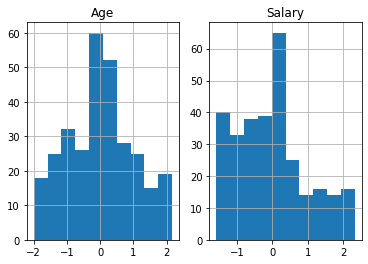

In [6]:
mv = np.mean(X_train,axis=0)
print(f"Mean values are: {mv}")

plt.subplot(1,2,1)
plt.hist(X_train[:,0])
plt.grid(True)
plt.title("Age");

plt.subplot(1,2,2)
plt.hist(X_train[:,1])
plt.grid(True)
plt.title("Salary");

## Training the Kernel SVM model on the Training set

In [10]:
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

evaluate(y_test, y_pred)

Confusion Matrix:
 [[64  4]
 [ 3 29]]
-------------------
True Positives (TP): 64
True Negatives (TN): 29
False Positives (FP): 4
False Negatives (FN): 3
-------------------
Accuracy: 93.0%


In [13]:
# k-fold cross validataion
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 90.33 %
Standard Deviation: 6.57 %


## Applying Grid Search to find the best model and the best parameters

In [14]:
parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10, # num train test folds
                           n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print(f"Best Accuracy: {best_accuracy*100:.2f} %")
print(f"Best Parameters: {best_parameters}")

Best Accuracy: 90.67 %
Best Parameters: {'C': 0.5, 'gamma': 0.6, 'kernel': 'rbf'}


Optimal classifier: SVC(C=0.5, gamma=0.6, random_state=0)


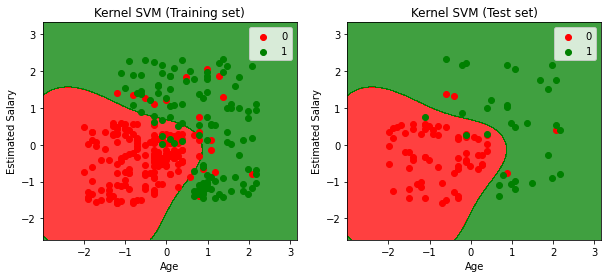

In [42]:
bp = best_parameters
classifier = SVC(random_state = 0, kernel=bp["kernel"], gamma=bp["gamma"], C=bp["C"])
classifier.fit(X_train, y_train)

print(f"Optimal classifier: {classifier}")

plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plot(classifier, X_train, y_train, 'Kernel SVM (Training set)')
plt.subplot(122)
plot(classifier, X_test, y_test, 'Kernel SVM (Test set)')